# STINTSY Technical Document

### Group FOP:
- Keil Christopher Finez
- Azriel Matthew Ortega
- James Andrew Perez

### Section
- S11

## Description of the Dataset and Task
- An overview or description of the data is provided, including how it was collected, and its implications on the types of conclusions that could be made from the data. A description of the variables, observations, and/or structure of the data is provided. The target task is well introduced and clearly defined.

### Dataset
The Fingers Dataset contains images of a hand holding up fingers from 0 - 5. It includes left-hand and right-hand images, where the left-hand images are generated by flipping the right-hand images. There are 21600 images and have a size of 128 by 128 pixels. The training set will use 18000 images, and the testing set will have 3600. Images are pre-processed by centering them by their center of mass and adding noise patterns to the background. The images were labeled from the last two characters of their file name, L and R for Left and Right; 0,1,2,3,4,5 for the number of fingers raised.

### Task
The goal of this project is to identify the number of fingers the hand is holding, and distinguish between left and right hand.

### Pre Processing

Import all of the necessary libraries

In [1]:
from PIL import Image
import os
import random
import cv2, torch
import itertools
import shutil
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix

%matplotlib inline

C:\Users\Matt\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# define resize images function
def resize():
    for item in dirs:
        if os.path.isfile(path+item):
            im = Image.open(path+item)
            f, e = os.path.splitext(dest+item)
            imResize = im.resize((224,224), Image.ANTIALIAS)
            imResize.save(f + ' resized.png', 'PNG', quality=90)

In [3]:
# resize train images
path = "dest_dataset/train/"
dest = "dest_dataset/resized_train/"
dirs = os.listdir(path)

# Dont run it again if images are already resized
#resize()

In [4]:
# resize test images
path = "dest_dataset/test/"
dest = "dest_dataset/resized_test/"
dirs = os.listdir(path)

# Dont run it again if images are already resized
#resize()

### Data pre-processing
In the case of the dataset given by Kaggle, the group did not perform any data pre-processing on the dataset due to it already being pre-processed when downloaded. For the Fingers dataset, the providers had already made the images black and white, made the hands placed in the center through the center of mass, sized at 128x128 pixels, and added noise. No pre-processing was done due to the images being formatted in such a way that it is ready for training.

### Cleaning
No cleaning was done as all data provided were pre-processed and numbered evenly. Upon inspection of the provided dataset, there are 9000 images for the left hand and right hand in training which totals to 18000, and 1800 images for the left and right hand in testing which totals to 3600.

### Loading the Dataset

Get the file path for training and test data

In [5]:
trainpath = os.listdir("dest_dataset/resized_train")
testpath = os.listdir("dest_dataset/resized_test")

Put the file paths on the Dataframe

In [6]:
trainpath = ['dest_dataset/resized_train/' + i for i in trainpath]
testpath = ["dest_dataset/resized_test/" + i for i in testpath]

In [7]:
traindata = pd.DataFrame(trainpath, columns=['FilePath'])
testdata = pd.DataFrame(testpath, columns=['FilePath'])

Insert the labels of the images by getting the last two letters of the file name

In [8]:
traindata['Fingers'] = traindata['FilePath'].apply(lambda a: a[-14:-13])
testdata['Fingers'] = testdata['FilePath'].apply(lambda a: a[-14:-13])
traindata['Hand'] = traindata['FilePath'].apply(lambda a: a[-13:-12])
testdata['Hand'] = testdata['FilePath'].apply(lambda a: a[-13:-12])

In [9]:
traindata

,FilePath,Fingers,Hand
0,dest_dataset/resized_train/00048bba-979b-4f84-...,0,L
1,dest_dataset/resized_train/000547a2-d456-4b16-...,0,L
2,dest_dataset/resized_train/000cac8e-fcf0-4f8c-...,2,L
3,dest_dataset/resized_train/000d9961-8136-4dee-...,0,L
4,dest_dataset/resized_train/0010095b-2e3d-4517-...,5,L
...,...,...,...
17995,dest_dataset/resized_train/ffed5de7-577a-49f8-...,0,L
17996,dest_dataset/resized_train/ffef96a9-fe26-4e07-...,4,L
17997,dest_dataset/resized_train/fff5517f-6329-4588-...,0,R
17998,dest_dataset/resized_train/fff79b8e-4d29-4cfa-...,2,L


In [10]:
testdata

,FilePath,Fingers,Hand
0,dest_dataset/resized_test/000e7aa6-100b-4c6b-9...,5,L
1,dest_dataset/resized_test/001f6021-8581-4ed2-a...,5,L
2,dest_dataset/resized_test/0027029b-4c3c-4785-b...,3,R
3,dest_dataset/resized_test/004599fb-c735-4ff3-a...,5,L
4,dest_dataset/resized_test/00500e1a-f4bd-4f66-9...,5,L
...,...,...,...
3595,dest_dataset/resized_test/ff78cf4f-d03c-4b41-9...,2,R
3596,dest_dataset/resized_test/ff8be861-dd82-4500-8...,0,L
3597,dest_dataset/resized_test/ff9eeef5-2c62-4bce-9...,4,R
3598,dest_dataset/resized_test/ffb7e43c-deac-4b8f-8...,3,R


## Exploratory Data Analysis
-  Appropriate summaries and visualizations are presented. Insights into how the EDA can help the model training is mentioned.

In [11]:
print("Total train data:", len(traindata))
print("Total test data:", len(testdata))

Total train data: 18000
Total test data: 3600


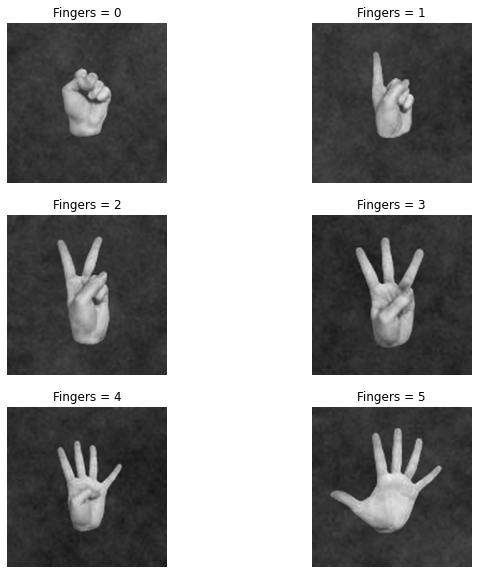

In [12]:
# print all first occurence of number of fingers raised (0-5)
fig = plt.figure(figsize=(10, 10))

for i in range (6):
    idx=(traindata.Fingers.values == str(i)).argmax()
    fig.add_subplot(3 ,2 , i+1)
    
    plt.imshow(cv2.imread(traindata.FilePath[idx]))
    plt.axis('off')
    plt.title("Fingers = " + str(i))

In [13]:
# determine image count for training per finger
traindata['Fingers'].value_counts()

0    3000
2    3000
5    3000
3    3000
4    3000
1    3000
Name: Fingers, dtype: int64

In [14]:
# determine image count for training per hand
traindata['Hand'].value_counts()

L    9000
R    9000
Name: Hand, dtype: int64

Text(0.5, 1.0, 'Right Hand')

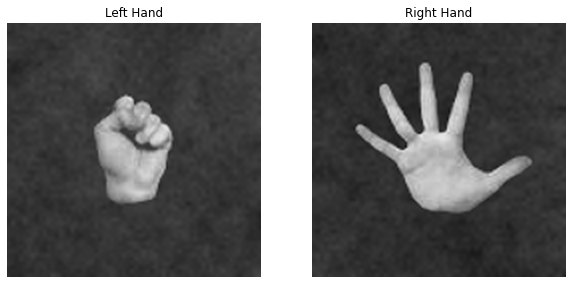

In [15]:
## print all first occurence of left and right hand
fig = plt.figure(figsize=(10, 10))

idx=(traindata.Hand.values == "L").argmax()
fig.add_subplot(1 ,2 , 1)
plt.imshow(cv2.imread(traindata.FilePath[idx]))
plt.axis('off')
plt.title("Left Hand")

idx=(traindata.Hand.values == "R").argmax()
fig.add_subplot(1 ,2 , 2)
plt.imshow(cv2.imread(traindata.FilePath[idx]))
plt.axis('off')
plt.title("Right Hand")

In [16]:
# determine image count for testing per finger
testdata['Fingers'].value_counts()

5    600
3    600
4    600
2    600
1    600
0    600
Name: Fingers, dtype: int64

In [17]:
# determine image count for testing per hand
testdata['Hand'].value_counts()

L    1800
R    1800
Name: Hand, dtype: int64

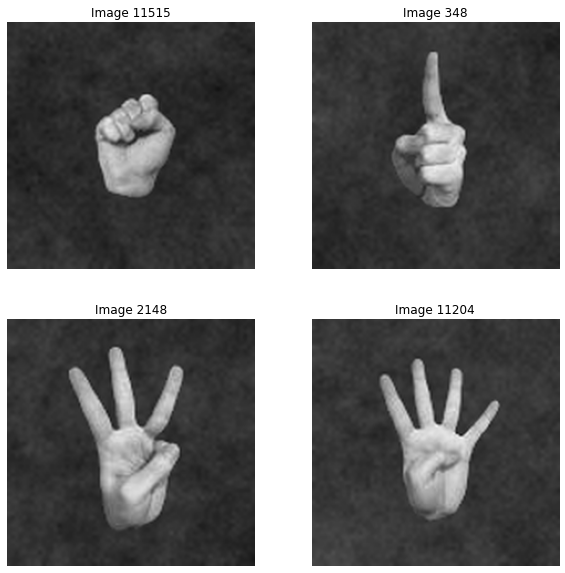

In [18]:
#print 4 random images from train dataset

fig = plt.figure(figsize=(10, 10))
for i in range (4):
    idx = random.randint(0, 17999)
    fig.add_subplot(2 ,2 , i+1)
    
    plt.imshow(cv2.imread(traindata.FilePath[idx]))
    plt.axis('off')
    plt.title("Image " + str(idx))

## Model Training
- The appropriate models are used to accomplish the machine learning task. Justification of choosing the models is shown.

### RESNET50

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

In [ ]:
#load data
import glob

train_images = glob.glob('dest_dataset/resized_test/*.png')
test_images = glob.glob('dest_dataset/resized_train/*.png')
print(len(train_images), len(test_images))

In [ ]:
import cv2, torch
from torch.utils.data import Dataset, DataLoader

transform = transforms.Compose(transforms.ToTensor())

#dataset and dataloader for train
class dataset(Dataset) :
    def __init__(self, image_list, transform, device) :
        self.image_list = image_list
        self.transform = transform
        self.device = device
        self.image_labels = [x[-14:-12] for x in self.image_list]
        for i, x in enumerate(self.image_labels) :
            label = int(x[0])
            if x[1] == 'R' : label += 6
            self.image_labels[i] = label
    
    def __len__(self) :
        return len(self.image_list)
    
    def __getitem__(self, index) :
        x = cv2.imread(self.image_list[index])
        x = self.transform(x).to(self.device)
        y = self.image_labels[index]
        y = torch.LongTensor([y,]).to(self.device)
        
        return x, y
        

#load train_images
train_data = dataset(train_images, transform, device)
train_data = DataLoader(train_data, batch_size = 32, shuffle = True)

#load test_images
test_data = dataset(test_images, transform, device)
test_data = DataLoader(test_data, batch_size = 32, shuffle = True)


In [ ]:
#!pip install torchsummaryX

In [ ]:
import torch.nn as nn
from torch.optim import Adam
from torchvision.models import resnet50
from torchsummaryX import summary

class resnet(nn.Module) :
    def __init__(self, output) :
        super().__init__()
        self.model = resnet50(pretrained=False) #use Densenet
        self.model.fc = torch.nn.Linear(2048, output) #change the last FC layer
        
    def forward(self, x) :
        output = self.model(x)
        return output

classes = 12
model = resnet(classes).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

summary(model, torch.rand((1, 3, 224, 224)).float().to(device))

In [ ]:
from tqdm.notebook import tqdm

n_epoch = 10
previous_loss = 0
torch.cuda.empty_cache()

model = model.train()

for epoch in range(n_epoch) :
    epoch_loss = 0
    epoch_acc = 0
    for i, (x, y) in tqdm(enumerate(train_data)) :
        y = y.reshape(-1)
        
        predict = model(x)
        loss = criterion(predict, y)
        
        epoch_loss += loss / len(train_data)
        correct_prediction = torch.argmax(predict, 1) == y
        correct_prediction = correct_prediction.sum()
        epoch_acc += correct_prediction
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    epoch_acc = epoch_acc / (32 * len(train_data))
    print('Epoch : {}/{},   loss : {:.5f},    acc : {:.5f}'.format(epoch+1, n_epoch, epoch_loss, epoch_acc))
    
    if abs(previous_loss - epoch_loss) < 0.05 : 
        break
    else:
        previous_loss  = epoch_loss

In [ ]:
with torch.no_grad() :
    val_loss = 0
    val_acc = 0
    for i, (x, y) in enumerate(test_data) :
        y = y.reshape(-1)
        
        predict = model(x)
        loss = criterion(predict, y)

        val_loss += loss / len(test_data)
        correct_prediction = torch.argmax(predict, 1) == y # [True, Flase, True ...]
        correct_prediction = correct_prediction.sum()
        val_acc += correct_prediction
          
        #Visualize 5 items for 5 batchs
        if i < 5 :
            r = random.sample(range(0, len(x)), 5)
            fig = plt.figure(figsize = (22, 22))
            result_list = ['left_0', 'left_1', 'left_2', 'left_3', 'left_4', 'left_5', 
                          'right_0', 'right_1', 'right_2', 'right_3', 'right_4', 'right_5']
            for i in range(5) :
                label = predict[r[i]]
                label = torch.argmax(label).item()

                img = x[r[i]].to('cpu').numpy()
                img = np.transpose(img, (1,2,0))

                subplot = fig.add_subplot(1, 5, i+1)
                subplot.set_title(result_list[label])
                subplot.imshow(img, cmap=plt.cm.gray_r)
            plt.show()
    
    val_acc = val_acc.item() / (32 * len(test_data))
    print('loss : {:.5f},    acc : {:.5f}'.format(val_loss, val_acc))

### MOBILENETV2

In [ ]:
y_1 = []
y_2 = []
for i in range (len(traindata)):
    if traindata.iloc[i].Hand == "R":
        y_1.append(str(int(traindata.iloc[i].Fingers) + 6))
    else:
        y_1.append(str(int(traindata.iloc[i].Fingers)))
        
traindata['y'] = y_1
traindata.drop('Fingers', inplace=True, axis=1)
traindata.drop('Hand', inplace=True, axis=1)

for i in range (len(testdata)):
    if testdata.iloc[i].Hand == "R":
        y_2.append(str(int(testdata.iloc[i].Fingers) + 6))
    else:
        y_2.append(str(int(testdata.iloc[i].Fingers)))
        
testdata['y'] = y_2
testdata.drop('Fingers', inplace=True, axis=1)
testdata.drop('Hand', inplace=True, axis=1)

In [ ]:
traindata

In [ ]:
mobile = tf.keras.applications.MobileNetV2()
mobile.summary()

In [ ]:
x = mobile.layers[-2].output #get 2nd last layer 
output = Dense(units=12, activation='softmax')(x)

model = Model(inputs=mobile.input, outputs=output)

In [ ]:
for layer in model.layers[:-23]:
    layer.trainable = False
    
model.summary()

In [ ]:
train_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input,validation_split=0.1)

In [ ]:
train_batches=train_generator.flow_from_dataframe(
    dataframe=traindata,
    x_col='FilePath',
    y_col='y',
    class_mode='categorical',
    color_mode='rgb',
    batch_size=32,
    subset='training')

In [ ]:
valid_batches=train_generator.flow_from_dataframe(
    dataframe=traindata,
    x_col='FilePath',
    y_col='y',
    class_mode='categorical',
    color_mode='rgb',
    batch_size=32,
    subset='validation')

In [ ]:
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_dataframe(
    dataframe=testdata,
    x_col='FilePath',
    y_col='y',
    class_mode='categorical',
    color_mode='rgb',
    batch_size=32,
    shuffle=False)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(train_batches, validation_data=valid_batches, verbose=1, epochs=3)

In [ ]:
predictions = model.predict(test_batches)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=predictions.argmax(axis=1))
test_labels = test_batches.classes

In [ ]:
cm_plot_labels = ['0','1','2','3','4','5','6','7','8','9','10','11']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_readable = le.fit_transform(traindata['y'])

In [ ]:
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})
y_pred = predictions.argmax(axis=1)

for i, ax in enumerate(axes.flat):
    true_label = testdata.y.iloc[i]
    pred_label = le.inverse_transform([y_pred[i]])[0]
    
    if int(true_label) > 5:
        true_label = str(int(true_label) - 6) + " Right Hand"
    else:
        true_label = str(true_label) + " Left Hand"
        
    if int(pred_label) > 5:
        pred_label = str(int(pred_label) - 6) + " Right Hand"
    else:
        pred_label = str(pred_label) + " Left Hand"
        
    ax.imshow(plt.imread(testdata.FilePath.iloc[i]), cmap='gray')
    ax.set_title(f"True: {true_label}\nPredicted: {pred_label}")
plt.tight_layout()
plt.show()

## Model selection and hyperparameter tuning
- Appropriate data-driven error analysis is made, and changes to the model selection and hyperparameters are performed to improve model performance. The study exhausts improvements that can be done to the model